# Inicialização

In [1]:
import os
import tempfile

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly as py

from datetime import datetime
from datetime import timedelta

import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

import tensorflow.keras as keras
import tensorflow as tf

from imblearn.over_sampling import SMOTE

In [2]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Funções

In [4]:
def upsampleData(X, label):
    # Separar verdadeiro e falso
    false_label = X[X[label]==0].copy()
    true_label = X[X[label]==1].copy()
    
    # Realizar upsample para os valores verdadeiros
    label_upsampled = resample(true_label,
                            replace=True, # sample with replacement
                            n_samples=len(false_label), # match number in majority class
                            random_state=378) # reproducible results
    upsampled = pd.concat([false_label, label_upsampled])
    
    # Separar x e y
    x = upsampled[[c for c in X.columns if label not in c]]
    y = upsampled[label]
    
    return x, y

In [32]:
def downsampleData(df, days):
    if days == 0:
        return df
    
    all_dates = pd.to_datetime(df.loc[df.Label == 1, 'Data_Hora'].dt.strftime('%Y-%m-%d'), yearfirst=True)
    under_dates = list()
    
    for i in range(days+1):
        under_dates.append(all_dates - timedelta(days=i))
        
    df_aux = df[df['Data_Hora'].dt.strftime('%Y-%m-%d').isin(pd.concat(under_dates).dt.strftime('%Y-%m-%d').unique())]
    
    return df_aux  

In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(shape, metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    adam = Adam(lr=0.001)

    model = Sequential()
    #model.add(LSTM(64, return_sequences=True, input_shape=(shape[1], shape[2])))
    model.add(LSTM(64, return_sequences=True, input_shape=(shape[1], shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    #model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

    return model

In [7]:
EPOCHS = 10
BATCH_SIZE = 200

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [8]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

In [9]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [67]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Não ocorreu enchente (Verdadeiro Negativo): ', cm[0][0])
  print('Não ocorreu enchente mas detectou (Falso Positivo): ', cm[0][1])
  print('Ocorreu enchente e não detectou (Falso Negativo): ', cm[1][0])
  print('Ocorreu enchente e detectou (Verdadeiro Positivo): ', cm[1][1])
  print('Total de enchentes: ', np.sum(cm[1]))

In [11]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Preparar dados

## Operações básicas

In [12]:
df = pd.read_csv('../../../data/cleandata/Info pluviometricas/Merged Data/full_data.csv', sep=';')

# Escolher label e remover outras labels desnecessárias
cols_rem = ['LocalMax_d_ow', 'LocalMax_h_All', 'LocalMax_h', 'LocalMax_h_ow', 'LocalMax_d', 'Local'] + [c for c in df.columns if 'Local_' in c]
df = df[df['Local'] == 'Camilopolis'].drop(columns = cols_rem).rename(columns = {'LocalMax_d_All': 'Label'}).sort_values(by='Data_Hora')

# Colunas de data
df['Data_Hora'] = pd.to_datetime(df['Data_Hora'], yearfirst=True)
df = df[df['Data_Hora'].dt.minute == 0]
df['Dia'] = df['Data_Hora'].dt.day
df['Mes'] = df['Data_Hora'].dt.month

# Reordernar colunas
df = df[df.columns.drop('Label').to_list() + ['Label']]
df = df.reset_index(drop=True)

#df = df[0:1000]

display(df.head())
print(df.shape)

,Data_Hora,UmidadeRelativa,PressaoAtmosferica,TemperaturaDoAr,PontoDeOrvalho,RadiacaoSolar,DirecaoDoVento,VelocidadeDoVento,Precipitacao,Dia,Mes,Label
0,2011-01-01 00:00:00,84.8,920.6,20.2,17.5,0.0,137.0,1.5,0.0,1,1,0.0
1,2011-01-01 01:00:00,84.0,919.9,20.1,17.3,0.0,151.0,1.8,0.0,1,1,0.0
2,2011-01-01 02:00:00,85.8,919.2,19.8,17.4,0.0,155.0,1.8,0.0,1,1,0.0
3,2011-01-01 03:00:00,87.6,918.6,19.5,17.3,0.0,152.0,1.5,0.0,1,1,0.0
4,2011-01-01 04:00:00,87.4,918.4,19.4,17.2,0.0,147.0,1.6,0.0,1,1,0.0


(76681, 12)


## Contagem negativo/positivo

In [13]:
neg, pos = np.bincount(df['Label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 76681
    Positive: 1992 (2.60% of total)



# Modelagem

## Downsample e Scale

In [33]:
# Opcional: undersampling (0 para não realizar)
days = 2

train_df = downsampleData(df, days)
# under_dates = pd.to_datetime(df.loc[df.Label == 1, 'Data_Hora'].dt.strftime('%Y-%m-%d'), yearfirst=True)
# train_df = df[df['Data_Hora'].dt.strftime('%Y-%m-%d').isin(pd.concat([under_dates, under_dates - timedelta(days=1), under_dates - timedelta(days=2)]).dt.strftime('%Y-%m-%d').unique())]
train_df = train_df.drop(columns=['Data_Hora', 'DirecaoDoVento', 'VelocidadeDoVento'])

In [34]:
train_labels = np.array(train_df.pop('Label'))
bool_train_labels = train_labels != 0

train_features = np.array(train_df)

In [35]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

train_features = np.clip(train_features, -5, 5)

## Prep data for LSTM

### Obter acumulado das features

In [36]:
train_df = pd.DataFrame(train_features)
input_cols = train_df.columns

train_df['input_vector'] = train_df[input_cols].apply(tuple, axis=1).apply(list)
train_df['input_vector'] = train_df.input_vector.apply(lambda x: [list(x)])
#train_df['cumulative_input_vectors'] = train_df.input_vector.cumsum()
#df['cumulative_input_vectors'] = df.input_vector.rolling(min_periods=1, window=200).sum()

In [37]:
cumulative_input_vectors = []
steps = 48

for i in range(train_df.shape[0]):
    min_ = max(0, i+1 - steps)
    max_ = min(train_df.shape[0], i+1)
    #print(f'{min_} - {max_}')
    
    cumulative_input_vectors.append(train_df['input_vector'][min_:max_].sum())
    
    print(f'{i}/{train_df.shape[0]-1}', end='\r')

In [38]:
max_sequence_length = 48 #df.cumulative_input_vectors.apply(len).max()
# Save it as a list   
padded_sequences = pad_sequences(cumulative_input_vectors, max_sequence_length, dtype='float').tolist()
train_df['padded_input_vectors'] = pd.Series(padded_sequences).apply(np.asarray)

### Reshape

In [45]:
df_aux = pd.concat([train_df['padded_input_vectors'], pd.DataFrame(train_labels)], axis=1).rename(columns={0:'Label'})

In [46]:
# Extract your training data
df_aux_train = df_aux[:int(df_aux.shape[0]*0.7)].copy()
df_aux_test = df_aux[int(df_aux.shape[0]*0.7):].copy()

# X_train, y_train = upsampleData(df_aux_train, 'Label')
# train_re = pd.concat([X_train, y_train], axis=1)

train_re = df_aux_train.copy()
#train_re['Label'] = train_labels

X_train_init = np.asarray(train_re.padded_input_vectors)
# Use hstack to and reshape to make the inputs a 3d vector
X_train = np.hstack(X_train_init).reshape(len(train_re),max_sequence_length,len(input_cols))
y_train = np.hstack(np.asarray(train_re.Label)).reshape(len(train_re),1)

X_test_init = np.asarray(df_aux_test.padded_input_vectors)
# Use hstack to and reshape to make the inputs a 3d vector
X_test = np.hstack(X_test_init).reshape(len(df_aux_test),max_sequence_length,len(input_cols))
y_test = np.hstack(np.asarray(df_aux_test.Label)).reshape(len(df_aux_test),1)

In [47]:
# Get your input dimensions
# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])

In [48]:
train_features = X_train
train_labels = y_train

In [49]:
print(train_features.shape)
print(train_labels.shape)

(4183, 48, 8)
(4183, 1)


In [50]:
y_test.shape

(1793, 1)

In [51]:
print(train_labels.sum())
print(y_test.sum())

1392.0
600.0


## Make Model

In [52]:
model = make_model(shape=train_features.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 64)            18688     
_________________________________________________________________
dropout (Dropout)            (None, 48, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 51,777
Trainable params: 51,777
Non-trainable params: 0
_________________________________________________________________


In [53]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6929


## Change initial bias

In [54]:
total = train_labels.shape[0]
pos = train_labels.sum()
neg = total - pos

In [55]:
initial_bias = np.log([pos/neg])
initial_bias

array([-0.69565839])

In [56]:
model = make_model(output_bias = initial_bias, shape=train_features.shape)
model.predict(X_test[:10])

array([[0.5314876 ],
       [0.4734358 ],
       [0.49341285],
       [0.5316516 ],
       [0.53142715],
       [0.5597217 ],
       [0.526137  ],
       [0.46190482],
       [0.49906564],
       [0.4797932 ]], dtype=float32)

In [57]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6978


In [58]:
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6968


### Testes com o bias

In [59]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [60]:
model = make_model(shape=train_features.shape)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=0)

In [61]:
model = make_model(shape=train_features.shape)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=0)

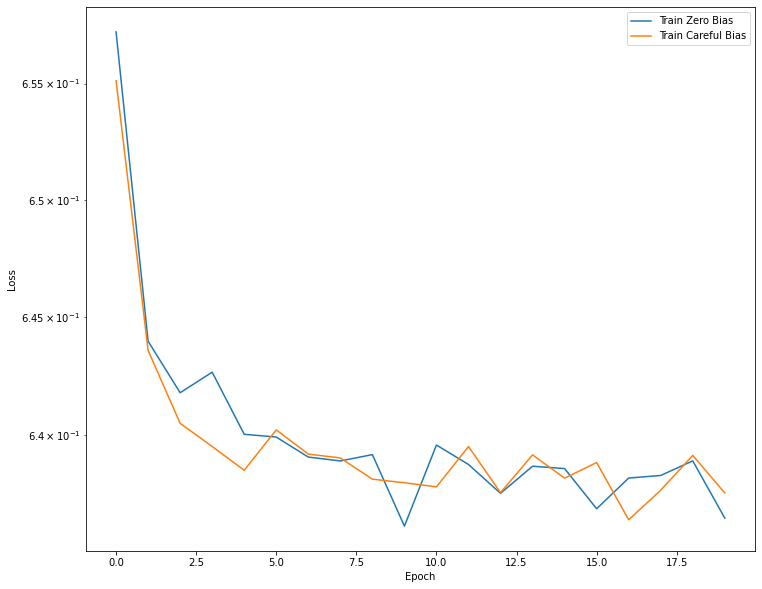

In [62]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Treinar modelo real

In [63]:
model = make_model(shape=train_features.shape)
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS+40,)

Epoch 1/50
21/21 [==============================] - 2s 82ms/step - loss: 0.6588 - tp: 113.0000 - fp: 221.0000 - tn: 5361.0000 - fn: 2671.0000 - accuracy: 0.6543 - precision: 0.3383 - recall: 0.0406 - auc: 0.4999
Epoch 2/50
21/21 [==============================] - 2s 81ms/step - loss: 0.6445 - tp: 0.0000e+00 - fp: 1.0000 - tn: 2790.0000 - fn: 1392.0000 - accuracy: 0.6670 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4784
Epoch 3/50
21/21 [==============================] - 2s 79ms/step - loss: 0.6396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2791.0000 - fn: 1392.0000 - accuracy: 0.6672 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5022
Epoch 4/50
21/21 [==============================] - 2s 82ms/step - loss: 0.6408 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2791.0000 - fn: 1392.0000 - accuracy: 0.6672 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4846
Epoch 5/50
21/21 [==============================] - 2s 79ms/step - loss: 0.6387 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

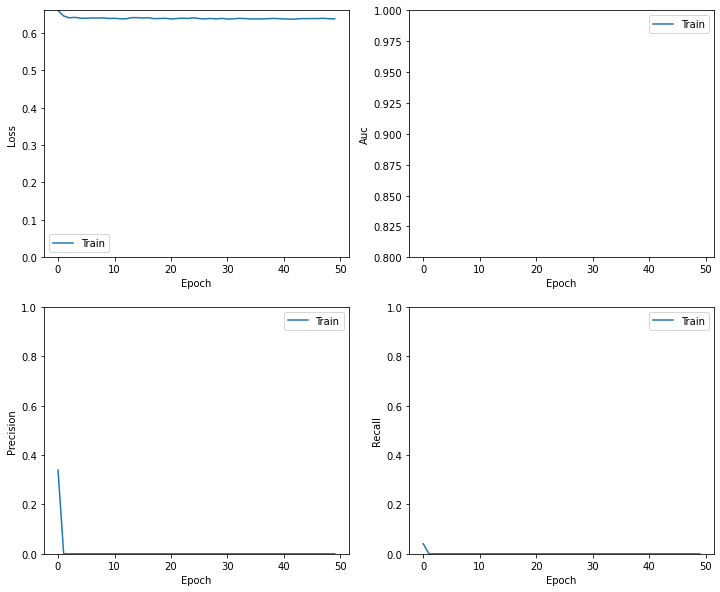

In [64]:
plot_metrics(baseline_history)

In [65]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

Não ocorreu enchente (Verdadeiro Negativo):  2791
Não ocorreu enchente mas detectou (Falso Positivo):  0
Ocorreu enchente e não detectou (Falso Negativo):  1392
Ocorreu enchente e detectou (Verdadeiro Positivo):  0
Total de enchentes:  1392
Não ocorreu enchente (Verdadeiro Negativo):  1193
Não ocorreu enchente mas detectou (Falso Positivo):  0
Ocorreu enchente e não detectou (Falso Negativo):  600
Ocorreu enchente e detectou (Verdadeiro Positivo):  0
Total de enchentes:  600


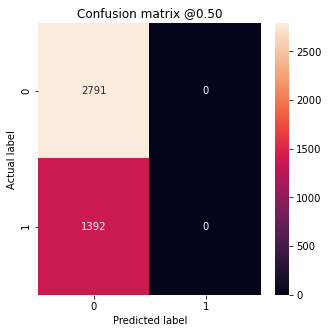

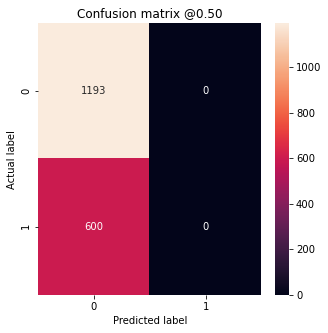

In [68]:
# baseline_results = model.evaluate(test_features, test_labels,
#                                   batch_size=BATCH_SIZE, verbose=0)
# for name, value in zip(model.metrics_names, baseline_results):
#   print(name, ': ', value)
# print()

plot_cm(train_labels, train_predictions_baseline)
plot_cm(y_test, test_predictions_baseline)

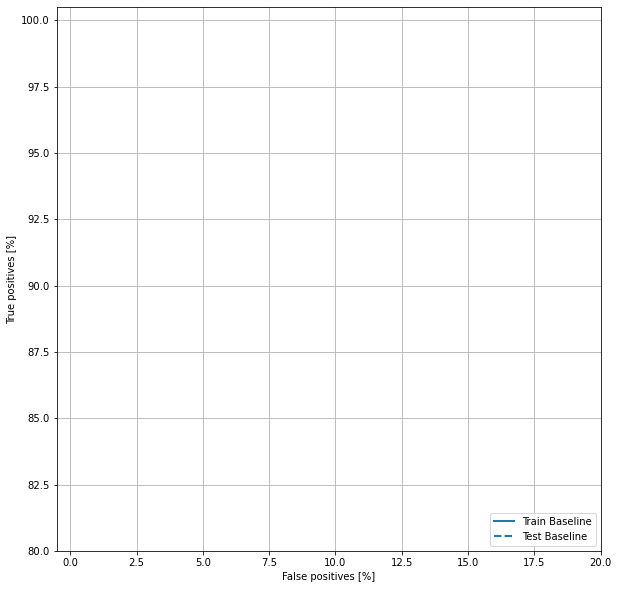

In [69]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Modificando peso das classes

In [70]:
total = train_labels.shape[0]
pos = train_labels.sum()
neg = total - pos

print(f'{total} - {pos} / {neg}')

4183 - 1392.0 / 2791.0


In [71]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#class_weight = {0: 4, 1: 16}

Weight for class 0: 0.75
Weight for class 1: 1.50


In [72]:
weighted_model = make_model(shape=train_features.shape)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS+40,
    callbacks = [early_stopping],
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/50
21/21 [==============================] - 2s 80ms/step - loss: 0.6994 - tp: 513.0000 - fp: 1089.0000 - tn: 4493.0000 - fn: 2271.0000 - accuracy: 0.5984 - precision: 0.3202 - recall: 0.1843 - auc: 0.4963
Epoch 2/50
21/21 [==============================] - 2s 81ms/step - loss: 0.6950 - tp: 861.0000 - fp: 1712.0000 - tn: 1079.0000 - fn: 531.0000 - accuracy: 0.4638 - precision: 0.3346 - recall: 0.6185 - auc: 0.5021
Epoch 3/50
21/21 [==============================] - 2s 82ms/step - loss: 0.6942 - tp: 704.0000 - fp: 1435.0000 - tn: 1356.0000 - fn: 688.0000 - accuracy: 0.4925 - precision: 0.3291 - recall: 0.5057 - auc: 0.4996
Epoch 4/50
21/21 [==============================] - 2s 81ms/step - loss: 0.6947 - tp: 721.0000 - fp: 1408.0000 - tn: 1383.0000 - fn: 671.0000 - accuracy: 0.5030 - precision: 0.3387 - recall: 0.5180 - auc: 0.5019
Epoch 5/50
21/21 [==============================] - 2s 80ms/step - loss: 0.6949 - tp: 796.0000 - fp: 1608.0000 - tn: 1183.0000 - fn: 596.0000 - accurac

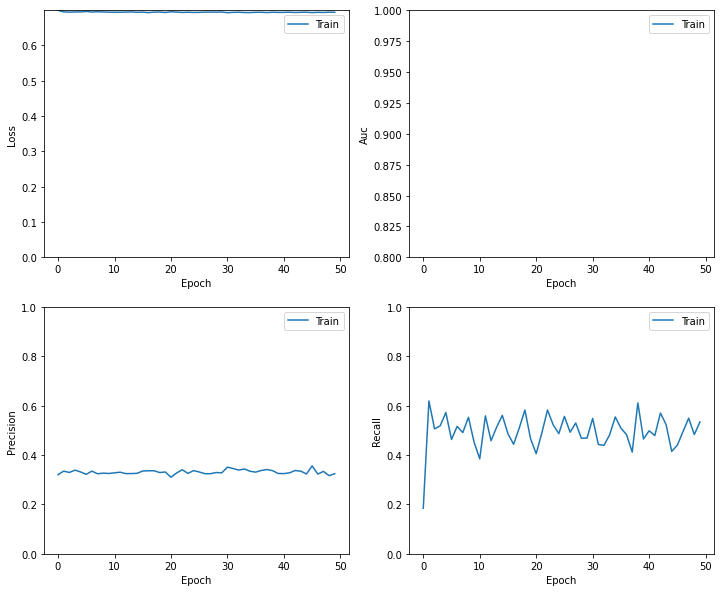

In [73]:
plot_metrics(weighted_history)

In [74]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

Não ocorreu enchente (Verdadeiro Negativo):  2791
Não ocorreu enchente mas detectou (Falso Positivo):  0
Ocorreu enchente e não detectou (Falso Negativo):  1392
Ocorreu enchente e detectou (Verdadeiro Positivo):  0
Total de enchentes:  1392
Não ocorreu enchente (Verdadeiro Negativo):  478
Não ocorreu enchente mas detectou (Falso Positivo):  715
Ocorreu enchente e não detectou (Falso Negativo):  241
Ocorreu enchente e detectou (Verdadeiro Positivo):  359
Total de enchentes:  600


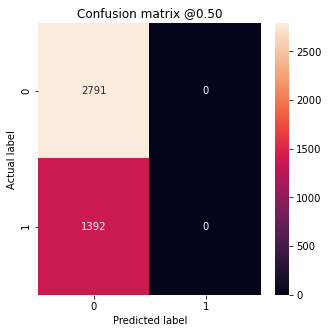

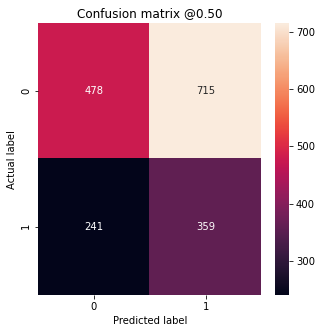

In [75]:
#test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

# weighted_results = weighted_model.evaluate(test_features, test_labels,
#                                            batch_size=BATCH_SIZE, verbose=0)
# for name, value in zip(weighted_model.metrics_names, weighted_results):
#   print(name, ': ', value)
# print()

plot_cm(train_labels, train_predictions_baseline)
plot_cm(y_test, test_predictions_baseline)